# Codon Usage Bias Analysis Across Species

## Introduction and Setup

**Codon usage bias** refers to the phenomenon where synonymous codons (codons encoding the same amino acid) are used with different frequencies. This bias varies across:
- Different species
- Different genes within the same organism
- Highly vs. lowly expressed genes

Why is this important?
1. Gene expression optimization
2. Heterologous protein expression
3. Evolutionary analysis
4. Gene origin prediction
5. Synthetic biology application

In [7]:
# Library
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# BioPython
from Bio import SeqIO

In [8]:
# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

## Codons

### Codon Table

In [9]:
# Standard genetic code (codon to amino acid mapping)
CODON_TABLE = {
    'TTT': 'F', 'TTC': 'F', 'TTA': 'L', 'TTG': 'L',
    'TCT': 'S', 'TCC': 'S', 'TCA': 'S', 'TCG': 'S',
    'TAT': 'Y', 'TAC': 'Y', 'TAA': '*', 'TAG': '*',
    'TGT': 'C', 'TGC': 'C', 'TGA': '*', 'TGG': 'W',
    'CTT': 'L', 'CTC': 'L', 'CTA': 'L', 'CTG': 'L',
    'CCT': 'P', 'CCC': 'P', 'CCA': 'P', 'CCG': 'P',
    'CAT': 'H', 'CAC': 'H', 'CAA': 'Q', 'CAG': 'Q',
    'CGT': 'R', 'CGC': 'R', 'CGA': 'R', 'CGG': 'R',
    'ATT': 'I', 'ATC': 'I', 'ATA': 'I', 'ATG': 'M',
    'ACT': 'T', 'ACC': 'T', 'ACA': 'T', 'ACG': 'T',
    'AAT': 'N', 'AAC': 'N', 'AAA': 'K', 'AAG': 'K',
    'AGT': 'S', 'AGC': 'S', 'AGA': 'R', 'AGG': 'R',
    'GTT': 'V', 'GTC': 'V', 'GTA': 'V', 'GTG': 'V',
    'GCT': 'A', 'GCC': 'A', 'GCA': 'A', 'GCG': 'A',
    'GAT': 'D', 'GAC': 'D', 'GAA': 'E', 'GAG': 'E',
    'GGT': 'G', 'GGC': 'G', 'GGA': 'G', 'GGG': 'G'
}

In [10]:
from collections import defaultdict

# Group codons by amino acids
def get_synonymous_codons():
    """Return dictionary of amino acids and their synonymous codons"""
    aa_codons = defaultdict(list)
    for codon, aa in CODON_TABLE.items():
        if aa != '*':       # Exclude stop codons
            aa_codons[aa].append(codon)
    return dict(aa_codons)

In [11]:
SYNONYMOUS_CODONS = get_synonymous_codons()
SYNONYMOUS_CODONS

{'F': ['TTT', 'TTC'],
 'L': ['TTA', 'TTG', 'CTT', 'CTC', 'CTA', 'CTG'],
 'S': ['TCT', 'TCC', 'TCA', 'TCG', 'AGT', 'AGC'],
 'Y': ['TAT', 'TAC'],
 'C': ['TGT', 'TGC'],
 'W': ['TGG'],
 'P': ['CCT', 'CCC', 'CCA', 'CCG'],
 'H': ['CAT', 'CAC'],
 'Q': ['CAA', 'CAG'],
 'R': ['CGT', 'CGC', 'CGA', 'CGG', 'AGA', 'AGG'],
 'I': ['ATT', 'ATC', 'ATA'],
 'M': ['ATG'],
 'T': ['ACT', 'ACC', 'ACA', 'ACG'],
 'N': ['AAT', 'AAC'],
 'K': ['AAA', 'AAG'],
 'V': ['GTT', 'GTC', 'GTA', 'GTG'],
 'A': ['GCT', 'GCC', 'GCA', 'GCG'],
 'D': ['GAT', 'GAC'],
 'E': ['GAA', 'GAG'],
 'G': ['GGT', 'GGC', 'GGA', 'GGG']}

### Count Codons

In [12]:
from collections import Counter

# Codon Counting Function
def count_codons(sequence):
    """Count codon frequencies in a DNA sequence"""
    sequence = sequence.upper().replace('U', 'T')

    # Ensure sequence length is divisible by 3
    if len(sequence) % 3 != 0:
        sequence = sequence[:(len(sequence) % 3)]

    # Collect the codons
    codons = [sequence[i:i+3] for i in range(0, len(sequence), 3)]

    # Filter valid codons
    valid_codons = [c for c in codons if c in CODON_TABLE and CODON_TABLE[c] != '*']

    return Counter(valid_codons)


### Calculate Relative Synonymous Codon Usage (RSCU)

In [13]:
def calculate_rscu(codon_counts):
    """
    Calculate Relative Synonymous Codon Usage (RSCU)

    RSCU = (observed frequency of codon) / (expected frequency if all synonymous codon used equally)
    RSCU = 1 means no bias
    RSCU > 1.0 means codon is used more than expected
    RSCU < 1.0 means codon is used less than expected

    Parameters:
    -----------
    codon_counts: Counter
        Codon Frequencies

    Returns:
    --------
    dict: RSCU values for each codon
    """
    rscu_values = {}

    for aa, codons in SYNONYMOUS_CODONS.items():
        # Count total usage of all synonymous codons for this amino acid
        total_aa_count = sum(codon_counts.get(codon, 0) for codon in codons)

        if total_aa_count == 0:
            continue

        # Calculate RSCU for each synonymous codon
        num_synonymous = len(codons)
        for codon in codons:
            observed = codon_counts.get(codon, 0)
            expected = total_aa_count / num_synonymous
            rscu_values[codon] = (observed / expected) if expected > 0 else 0

    return rscu_values

### Calculate Effective Number of Codons (ENC)

In [14]:
def calculate_enc(codon_counts):
    """
    Calculate Effective Number of Codons (ENC)

    ENC measures the overall codon usage bias in a gene
    Range: 20 (maximum bias) to 61 (no bias)

    Parameters:
    -----------
    codon_counts: Counter
        Codon Frequencies

    Returns:
    --------
    float: ENC Value
    """
    
    # Group amino acids by degeneracy
    two_fold = ['D', 'E', 'F', 'H', 'K', 'N', 'Q', 'Y', 'C']
    three_fold = ['I']
    four_fold = ['A', 'G', 'P', 'T', 'V']
    six_fold = ['L', 'R', 'S']

    def homozygosity(codons, codon_counts):
        """Calculate homozygosity for a group of synonymous codons"""
        total = sum(codon_counts.get(c, 0) for c in codons)
        if total == 0:
            return 0
        return sum((codon_counts.get(c, 0) / total) ** 2 for c in codons)

    # Calculate F values for each degeneracy class
    F2 = np.mean([homozygosity(SYNONYMOUS_CODONS[aa], codon_counts) for aa in two_fold if aa in SYNONYMOUS_CODONS])
    F3 = np.mean([homozygosity(SYNONYMOUS_CODONS['I'], codon_counts)])
    F4 = np.mean([homozygosity(SYNONYMOUS_CODONS[aa], codon_counts) for aa in four_fold if aa in SYNONYMOUS_CODONS])
    F6 = np.mean([homozygosity(SYNONYMOUS_CODONS[aa], codon_counts) for aa in six_fold if aa in SYNONYMOUS_CODONS])

    # Calculate ENC
    enc = 2 + 9/F2 + 1/F3 + 5/F4 + 3/F6 if all([F2, F3, F4, F6]) else 61

    return min(enc, 61) # Cap at 61

### Calculate Codon Adaptation Index (CAI)

In [15]:
def calculate_cai(codon_counts, reference_counts):
    """
    Calculate Codon Adaptation Index (CAI)

    CAI measures how similar a gene's codon usage is to highly expressed genes
    Range: 0 to 1 (higher = more similar to reference set)

    Parameters:
    -----------
    codon_counts: Counter
        Codon Frequencies in Gene
    reference_counts: Counter
        Codon Frequencies in reference set

    Returns:
    --------
    float: CAI Value
    """

    # Calculate relative adaptiveness (w) for each codon
    w_values = {}
    for aa, codons in SYNONYMOUS_CODONS.items():
        max_usage = max(reference_counts.get(c, 0) for c in codons)
        if max_usage == 0:
            continue
        for codon in codons:
            w_values[codon] = reference_counts.get(codon, 0) / max_usage

    # Calculate geometric mean of w values
    w_products = []
    for codon, count in codon_counts.items():
        if codon in w_values and count > 0:
            w_products.extend([w_values[codon]] * count)

    if not w_products:
        return 0
    
    cai = np.exp(np.mean(np.log(np.array(w_products) + 1e-10)))
    return cai

## Multi-Species Analysis

In [16]:
class CodonUsageAnalyzer:
    """Comprehensive codon usage analysis for multiple species"""

    def __init__(self):
        self.species_data = {}

    def add_species(self, species_name, sequences):
        """Add species data for analysis"""
        # Aggregate codon counts across all sequences
        total_counts = Counter()
        enc_values = []

        for seq in sequences:
            counts = count_codons(seq)
            total_counts.update(counts)
            enc_values.append(calculate_enc(counts))

        # Calculate RSCU
        rscu = calculate_rscu(total_counts)

        self.species_data[species_name] = {
            'codon_counts': total_counts,
            'rscu': rscu,
            'enc_mean': np.mean(enc_values),
            'enc_std': np.std(enc_values),
            'num_sequences': len(sequences)
        }

    def compare_species(self):
        """Create comparison dataframe for all species"""
        if not self.species_data:
            print("No species data available")
            return None
        
        comparison_data = []

        for species, data in self.species_data.items():
            for codon, rscu_value in data['rscu'].items():
                comparison_data.append({
                    'Species': species,
                    'Codon': codon,
                    'Amino_Acid': CODON_TABLE[codon],
                    'RSCU': rscu_value,
                    'Count': data['codon_counts'][codon]
                })

        return pd.DataFrame(comparison_data)
    
    def plot_rscu_heatmap(self, amino_acid=None):
        """Plot RSCU heatmap across species"""
        df = self.compare_species()
        if df is None:
            return

        if amino_acid:
            df = df[df['Amino_Acid'] == amino_acid]
            title = f'RSCU Heatmap for {amino_acid} Codons'
        else:
            title = 'RSCU Heatmap - All Codons'

        # Pivot for heatmap
        pivot_df = df.pivot(index='Codon', columns='Species', values='RSCU')

        plt.figure(figsize=(12, 8))
        sns.heatmap(pivot_df, annot=True, fmt='.2f', cmap='RdYlGn', center=1.0, vmin=0, vmax=2, cbar_kws={'label': 'RSCU'})
        plt.title(title, fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()

    def plot_enc_comparison(self):
        """Plot ENC distribution comparison across species"""
        species_names = list(self.species_data.keys())
        enc_means = [self.species_data[s]['enc_mean'] for s in species_names]
        enc_stds = [self.species_data[s]['enc_std'] for s in species_names]

        plt.figure(figsize=(10, 6))
        plt.bar(species_names, enc_means, yerr=enc_stds, capsize=10, alpha=0.7, edgecolor='black')
        plt.axhline(y=61, color='r', linestyle='--', label='No bias (ENC = 61)')
        plt.axhline(y=20, color='b', linestyle='--', label='Maximum Bias (ENC = 20)')
        plt.ylabel('Effective Number of Codons (ENC)', fontsize=12)
        plt.xlabel('Species', fontsize=12)
        plt.title('Codon Usage Bias Comparison (ENC)', fontsize=14, fontweight='bold')
        plt.legend()
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

    def calculate_gc_content(self):
        """Calculate GC content at different codon positions"""
        gc_data = []

        for species, data in self.species_data.items():
            gc1, gc2, gc3 = 0, 0, 0
            total = 0

            for codon, count in data['codon_counts'].items():
                gc1 += count if codon[0] in 'GC' else 0
                gc2 += count if codon[1] in 'GC' else 0
                gc3 += count if codon[2] in 'GC' else 0
                total += count

            if total > 0:
                gc_data.append({
                    'Species': species,
                    'GC1': gc1 / total,
                    'GC2': gc2 / total,
                    'GC3': gc3 / total,
                    'GC_total': (gc1 + gc2 + gc3) / (3 * total)
                })

        return pd.DataFrame(gc_data)
    
    def plot_gc_content(self, figsize=(12, 6)):
        """
        Plot GC content at codon positions
        """
        gc_df = self.calculate_gc_content()
        
        x = np.arange(len(gc_df))
        width = 0.2
        
        fig, ax = plt.subplots(figsize=figsize)
        
        bars1 = ax.bar(x - 1.5*width, gc_df['GC1'], width, label='GC1', color='#3498db')
        bars2 = ax.bar(x - 0.5*width, gc_df['GC2'], width, label='GC2', color='#2ecc71')
        bars3 = ax.bar(x + 0.5*width, gc_df['GC3'], width, label='GC3', color='#e74c3c')
        bars4 = ax.bar(x + 1.5*width, gc_df['GC_total'], width, label='GC Total', color='#95a5a6')
        
        ax.set_ylabel('GC Content (%)', fontsize=13, fontweight='bold')
        ax.set_xlabel('Species', fontsize=13, fontweight='bold')
        ax.set_title('GC Content at Codon Positions', fontsize=16, fontweight='bold', pad=20)
        ax.set_xticks(x)
        ax.set_xticklabels(gc_df['Species'], rotation=45, ha='right')
        ax.legend(fontsize=11)
        ax.grid(axis='y', alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        return gc_df

    def get_most_biased_codons(self, n=10):
        """
        Get most biased codons for each species
        
        Parameters:
        -----------
        n : int
            Number of top biased codons to return
        
        Returns:
        --------
        dict : Dictionary of species -> biased codons
        """
        biased_codons = {}
        
        for species, data in self.species_data.items():
            # Calculate deviation from RSCU = 1.0
            codon_bias = [(codon, abs(rscu - 1.0), rscu) 
                          for codon, rscu in data['rscu'].items()]
            # Sort by bias magnitude
            codon_bias.sort(key=lambda x: x[1], reverse=True)
            biased_codons[species] = codon_bias[:n]
        
        return biased_codons
    
    def print_summary(self):
        """
        Print comprehensive summary of analysis
        """
        print("\n" + "=" * 70)
        print("CODON USAGE ANALYSIS SUMMARY")
        print("=" * 70)
        
        for species, data in self.species_data.items():
            print(f"\n{species}:")
            print(f"  Sequences analyzed: {data['num_sequences']}")
            print(f"  Total codons counted: {sum(data['codon_counts'].values())}")
            print(f"  ENC: {data['enc_mean']:.2f} ± {data['enc_std']:.2f}")
            
            # GC content
            gc1, gc2, gc3, total = 0, 0, 0, 0
            for codon, count in data['codon_counts'].items():
                if codon[0] in 'GC': gc1 += count
                if codon[1] in 'GC': gc2 += count
                if codon[2] in 'GC': gc3 += count
                total += count
            
            if total > 0:
                print(f"  GC Content: {(gc1+gc2+gc3)/(3*total)*100:.1f}% "
                      f"(GC3: {gc3/total*100:.1f}%)")
            
            # Most biased codons
            biased = [(c, abs(r-1), r) for c, r in data['rscu'].items()]
            biased.sort(key=lambda x: x[1], reverse=True)
            print(f"  Most biased codon: {biased[0][0]} "
                  f"({CODON_TABLE[biased[0][0]]}) - RSCU: {biased[0][2]:.2f}")


### Generate Sample Sequences

In [17]:
def generate_sample_sequences(gc_bias=0.5, num_seqs=100, length=300):
    """
    Generate sample coding sequences for demonstration
    
    Parameters:
    -----------
    gc_bias: float
        GC content bias (0 to 1)
    num_seqs: int
        Number of sequences to generate
    length: int
        Length of each sequence (must be divisible by 3)
    """

    sequences = []
    codons = [c for c in CODON_TABLE.keys() if CODON_TABLE[c] != '*']

    # Weight codons by GC content
    weights = []
    for codon in codons:
        gc_count = codon.count('G') + codon.count('C')
        weight = gc_bias * gc_count + (1 - gc_bias) * (3 - gc_count)
        weights.append(weight)

    weights = np.array(weights) / sum(weights)

    for _ in range(num_seqs):
        seq_codons = np.random.choice(codons, size=length//3, p=weights)
        sequences.append(''.join(seq_codons))

    return sequences

In [18]:
analyzer = CodonUsageAnalyzer()

In [19]:
# Add sample data for three "species" with different biases
analyzer.add_species("High GC Organism", generate_sample_sequences(gc_bias=0.7, num_seqs=100))
analyzer.add_species("Neutral Organism", generate_sample_sequences(gc_bias=0.5, num_seqs=100))
analyzer.add_species("Low GC Organism", generate_sample_sequences(gc_bias=0.3, num_seqs=100))

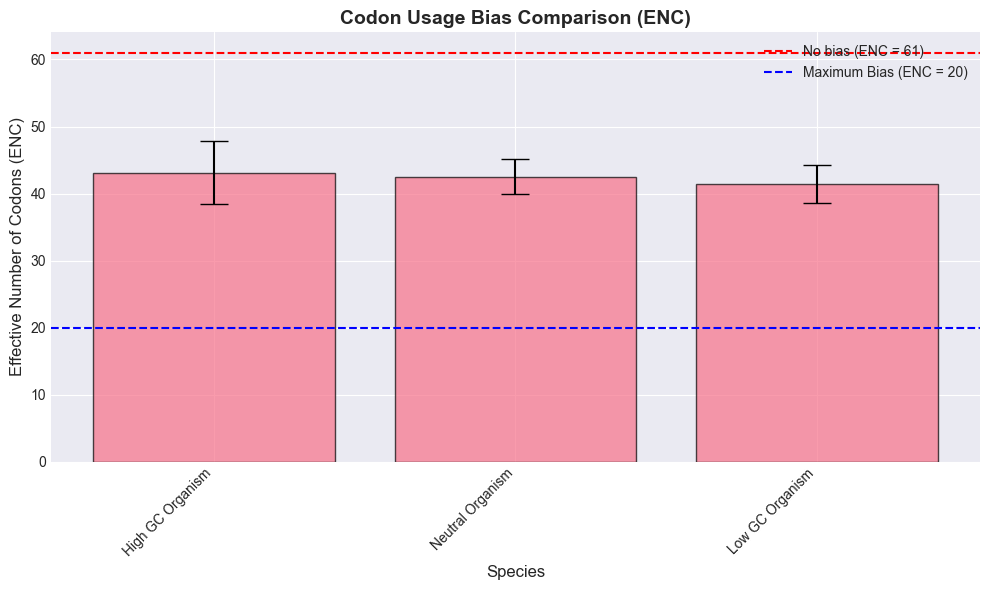

In [20]:
analyzer.plot_enc_comparison()

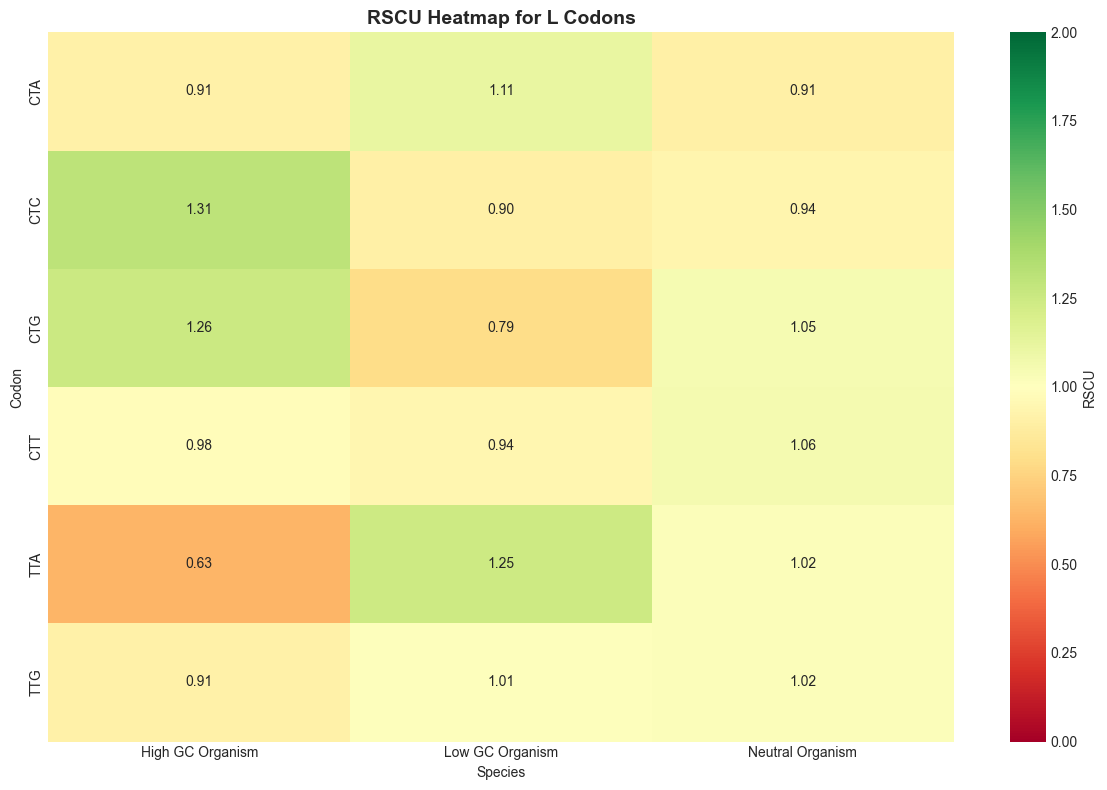

In [21]:
analyzer.plot_rscu_heatmap(amino_acid='L')

In [22]:
gc_df = analyzer.calculate_gc_content()
gc_df

,Species,GC1,GC2,GC3,GC_total
0,High GC Organism,0.5822,0.5749,0.5766,0.577900
1,Neutral Organism,0.5273,0.5010,0.5034,0.510567
2,Low GC Organism,0.4595,0.4425,0.4362,0.446067


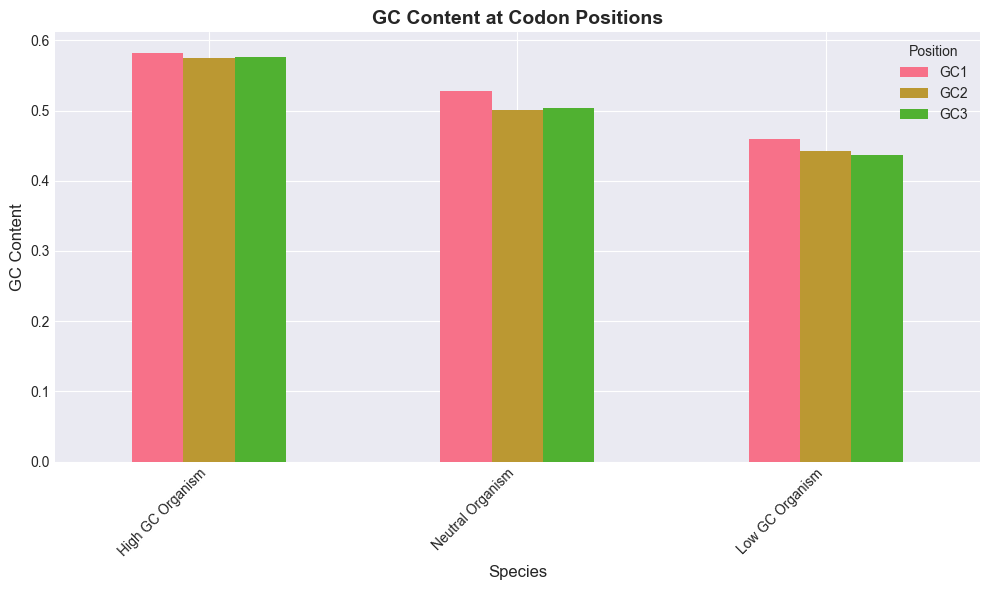

In [23]:
gc_plot = gc_df.set_index('Species')[['GC1', 'GC2', 'GC3']]
gc_plot.plot(kind='bar', figsize=(10, 6))
plt.ylabel('GC Content', fontsize=12)
plt.xlabel('Species', fontsize=12)
plt.title('GC Content at Codon Positions', fontsize=14, fontweight='bold')
plt.legend(title='Position')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [24]:
comparison_df = analyzer.compare_species()
for species in analyzer.species_data.keys():
    if comparison_df is None:
        continue
    species_df = comparison_df[comparison_df['Species'] == species]
    # Find codons with highest deviation from RSCU = 1.0
    species_df['Bias'] = abs(species_df['RSCU'] - 1.0)
    top_biased = species_df.nlargest(10, 'Bias')[['Codon', 'Amino_Acid', 'RSCU', 'Count']]
    print(f"\n{species}:")
    print(top_biased.to_string(index=False))



High GC Organism:
Codon Amino_Acid     RSCU  Count
  TTA          L 0.632319     90
  CTC          L 1.306792    186
  AGA          R 0.697417    126
  ACC          T 1.297806    207
  CAT          H 0.733728    124
  CAC          H 1.266272    214
  TCA          S 0.737160    122
  CTG          L 1.257611    179
  CCT          P 0.765133    158
  AAA          K 0.766129     95

Neutral Organism:
Codon Amino_Acid     RSCU  Count
  CGC          R 0.758621    121
  ACT          T 1.169036    185
  ACG          T 0.840442    133
  GGA          G 0.866359    141
  CAA          Q 0.869318    153
  CAG          Q 1.130682    199
  GGG          G 1.124424    183
  TCC          S 1.123404    176
  GTG          V 0.881029    137
  CGG          R 1.115987    178

Low GC Organism:
Codon Amino_Acid     RSCU  Count
  AGA          R 1.438509    193
  GCA          A 1.299578    154
  CCG          P 0.710204     87
  CGC          R 0.715528     96
  CGG          R 0.715528     96
  GAA          E 1.2

C:\Users\shres\AppData\Local\Temp\ipykernel_41004\552042065.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  species_df['Bias'] = abs(species_df['RSCU'] - 1.0)
C:\Users\shres\AppData\Local\Temp\ipykernel_41004\552042065.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  species_df['Bias'] = abs(species_df['RSCU'] - 1.0)
C:\Users\shres\AppData\Local\Temp\ipykernel_41004\552042065.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

## Read Data

In [28]:
from Bio import Entrez
import time

In [ ]:
Entrez.email = ""

In [55]:
def fetch_coding_sequences_from_ncbi(organism, gene_list, max_sequences=5):
    """
    Fetch coding sequences from NCBI for specified genes
    
    Parameters:
    -----------
    organism : str
        Scientific name of organism (e.g., "Escherichia coli")
    gene_list : list
        List of gene names/symbols
    max_sequences : int
        Maximum number of sequences to fetch per gene
    
    Returns:
    --------
    list : List of DNA sequences
    dict : Metadata about fetched sequences
    """
    print(f"\n{'='*70}")
    print(f"Fetching sequences for {organism}")
    print(f"{'='*70}")
    
    sequences = []
    metadata = {'organism': organism, 'genes': {}}
    
    for gene in gene_list:
        gene_seq_count = 0
        try:
            print(f"\n🔍 Searching for gene: {gene}...")
            
            # METHOD 1: Try searching protein database first (more reliable)
            print(f"  Method 1: Searching protein database...")
            search_term = f"{gene}[Gene] AND {organism}[Organism]"
            search_handle = Entrez.esearch(
                db="protein",
                term=search_term,
                retmax=max_sequences
            )
            search_results = Entrez.read(search_handle)
            search_handle.close()
            
            protein_ids = search_results.get("IdList", [])
            
            if protein_ids:
                print(f"    ✓ Found {len(protein_ids)} protein record(s)")
                
                for prot_id in protein_ids[:max_sequences]:
                    try:
                        # Fetch protein record to get coding sequence link
                        prot_handle = Entrez.efetch(
                            db="protein",
                            id=prot_id,
                            rettype="gb",
                            retmode="text"
                        )
                        prot_record = SeqIO.read(prot_handle, "genbank")
                        prot_handle.close()
                        
                        # Look for CDS link in db_xref
                        cds_id = None
                        for feature in prot_record.features:
                            if 'coded_by' in feature.qualifiers:
                                coded_by = feature.qualifiers['coded_by'][0]
                                # Extract accession from coded_by (format: "accession:start..end")
                                cds_id = coded_by.split(':')[0]
                                break
                        
                        if cds_id:
                            print(f"    → Found coding sequence: {cds_id}")
                            
                            # Fetch the nucleotide sequence
                            try:
                                nuc_handle = Entrez.efetch(
                                    db="nuccore",
                                    id=cds_id,
                                    rettype="fasta",
                                    retmode="text"
                                )
                                nuc_text = nuc_handle.read()
                                nuc_handle.close()
                                
                                # Parse FASTA
                                lines = nuc_text.strip().split('\n')
                                seq = ''.join(lines[1:]).upper().replace('U', 'T')
                                
                                if len(seq) >= 300 and len(seq) % 3 == 0:
                                    sequences.append(seq)
                                    gene_seq_count += 1
                                    print(f"      ✓ Added sequence ({len(seq)} bp)")
                                
                            except Exception as e:
                                print(f"      ✗ Error fetching nucleotide: {str(e)[:50]}")
                        
                        time.sleep(0.4)
                        
                        if gene_seq_count >= max_sequences:
                            break
                            
                    except Exception as e:
                        print(f"    ✗ Error with protein {prot_id}: {str(e)[:50]}")
                        time.sleep(0.4)
                        continue
            
            # METHOD 2: Try nucleotide database if protein search failed
            if gene_seq_count == 0:
                print(f"  Method 2: Searching nucleotide database...")
                search_term = f"{gene}[Gene] AND {organism}[Organism] AND (biomol_mrna[PROP] OR biomol_genomic[PROP])"
                search_handle = Entrez.esearch(
                    db="nuccore",
                    term=search_term,
                    retmax=max_sequences
                )
                search_results = Entrez.read(search_handle)
                search_handle.close()
                
                id_list = search_results.get("IdList", [])
                
                if id_list:
                    print(f"    ✓ Found {len(id_list)} nucleotide record(s)")
                    
                    for seq_id in id_list[:max_sequences]:
                        try:
                            # Fetch GenBank format
                            fetch_handle = Entrez.efetch(
                                db="nuccore",
                                id=seq_id,
                                rettype="gb",
                                retmode="text"
                            )
                            
                            record = SeqIO.read(fetch_handle, "genbank")
                            fetch_handle.close()
                            
                            print(f"    → Processing {seq_id} ({len(record.features)} features)")
                            
                            # Extract CDS features
                            cds_found_in_record = 0
                            for feature in record.features:
                                if feature.type == "CDS":
                                    try:
                                        cds_seq = str(feature.extract(record.seq))
                                        
                                        if len(cds_seq) >= 300 and len(cds_seq) % 3 == 0:
                                            sequences.append(cds_seq.upper().replace('U', 'T'))
                                            gene_seq_count += 1
                                            cds_found_in_record += 1
                                            
                                            if cds_found_in_record >= 2:
                                                break
                                    except Exception:
                                        continue
                            
                            if cds_found_in_record > 0:
                                print(f"      ✓ Extracted {cds_found_in_record} CDS")
                            
                            time.sleep(0.4)
                            
                            if gene_seq_count >= max_sequences:
                                break
                                
                        except Exception as e:
                            print(f"    ✗ Error with {seq_id}: {str(e)[:50]}")
                            time.sleep(0.4)
                            continue
            
            if gene_seq_count > 0:
                metadata['genes'][gene] = gene_seq_count
                print(f"  ✅ Successfully fetched {gene_seq_count} sequence(s) for {gene}")
            else:
                print(f"  ⚠️  No sequences found for {gene}")
            
        except Exception as e:
            print(f"  ❌ Error searching for {gene}: {str(e)}")
            continue
    
    print(f"\n{'='*70}")
    print(f"📊 TOTAL SEQUENCES FETCHED: {len(sequences)}")
    print(f"{'='*70}\n")
    
    return sequences, metadata



In [56]:
analyzer = CodonUsageAnalyzer()

In [49]:
ecoli_genes = ['thrA', 'rfbC', 'tmk', 'sthA', 'yehE', 'yadG', 'ndh']
ecoli_seqs, ecoli_meta = fetch_coding_sequences_from_ncbi(
    organism="Escherichia coli K-12",
    gene_list=ecoli_genes,
    max_sequences=2
)


Fetching sequences for Escherichia coli K-12

🔍 Searching for gene: thrA...
  Method 1: Searching protein database...
    ✓ Found 2 protein record(s)
    → Found coding sequence: NC_000913.3
  Method 2: Searching nucleotide database...
    ✓ Found 2 nucleotide record(s)
    → Processing 2806734189 (1 features)
    → Processing 2316089346 (1 features)
  ⚠️  No sequences found for thrA

🔍 Searching for gene: rfbC...
  Method 1: Searching protein database...
    ✓ Found 2 protein record(s)
    → Found coding sequence: complement(NC_000913.3
  Method 2: Searching nucleotide database...
    ✓ Found 2 nucleotide record(s)
    → Processing 2806734189 (1 features)
    → Processing 2316089346 (1 features)
  ⚠️  No sequences found for rfbC

🔍 Searching for gene: tmk...
  Method 1: Searching protein database...
    ✓ Found 2 protein record(s)
    → Found coding sequence: NC_000913.3
  Method 2: Searching nucleotide database...
    ✓ Found 2 nucleotide record(s)
    → Processing 2806734189 (1 fea

In [50]:
# If E. coli fetch fails, try alternative approach
if len(ecoli_seqs) == 0:
    print("\n⚠️  Standard fetch failed. Trying alternative approach...")
    print("   Fetching from E. coli K-12 genome (NC_000913)...")
    
    try:
        # Fetch genome annotation
        genome_handle = Entrez.efetch(
            db="nuccore",
            id="NC_000913.3",
            rettype="gb",
            retmode="text"
        )
        
        genome_record = SeqIO.read(genome_handle, "genbank")
        genome_handle.close()
        
        # Extract first 50 CDS features
        cds_count = 0
        for feature in genome_record.features:
            if feature.type == "CDS" and cds_count < 50:
                try:
                    cds_seq = str(feature.extract(genome_record.seq))
                    if len(cds_seq) >= 300 and len(cds_seq) % 3 == 0:
                        ecoli_seqs.append(cds_seq.upper())
                        cds_count += 1
                except:
                    continue
        
        print(f"  ✓ Fetched {len(ecoli_seqs)} CDS from E. coli genome")
        
    except Exception as e:
        print(f"  ✗ Alternative fetch also failed: {str(e)[:100]}")
        print("  ℹ️  Will continue with other species...")

analyzer.add_species("E. coli", ecoli_seqs)



⚠️  Standard fetch failed. Trying alternative approach...
   Fetching from E. coli K-12 genome (NC_000913)...
  ✓ Fetched 0 CDS from E. coli genome


c:\Users\shres\Projects\Learning-BioInformatics\.venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\shres\Projects\Learning-BioInformatics\.venv\Lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\shres\Projects\Learning-BioInformatics\.venv\Lib\site-packages\numpy\_core\_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\shres\Projects\Learning-BioInformatics\.venv\Lib\site-packages\numpy\_core\_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\shres\Projects\Learning-BioInformatics\.venv\Lib\site-packages\numpy\_core\_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rco

In [57]:
print("\n" + "="*70)
print("Fetching Human genes...")
print("="*70)
human_genes = ['GAPDH', 'ACTB', 'ALB']
human_seqs, human_meta = fetch_coding_sequences_from_ncbi(
    organism="Homo sapiens",
    gene_list=human_genes,
    max_sequences=3
)


Fetching Human genes...

Fetching sequences for Homo sapiens

🔍 Searching for gene: GAPDH...
  Method 1: Searching protein database...
    ✓ Found 3 protein record(s)
    → Found coding sequence: NM_001357943.2
    → Found coding sequence: NM_001289746.2
  Method 2: Searching nucleotide database...
    ✓ Found 3 nucleotide record(s)
    → Processing 2194973269 (1 features)
    → Processing 568815586 (1 features)
    → Processing 1676440496 (15 features)
      ✓ Extracted 1 CDS
  ✅ Successfully fetched 1 sequence(s) for GAPDH

🔍 Searching for gene: ACTB...
  Method 1: Searching protein database...
    ✓ Found 3 protein record(s)
    → Found coding sequence: XM_054343706.1
      ✓ Added sequence (9867 bp)
    → Found coding sequence: XM_054343705.1
    → Found coding sequence: XM_054332885.1
      ✓ Added sequence (7842 bp)
  ✅ Successfully fetched 2 sequence(s) for ACTB

🔍 Searching for gene: ALB...
  Method 1: Searching protein database...
    ✓ Found 3 protein record(s)
    → Found c

In [58]:
analyzer.add_species("H. sapiens", human_seqs)

In [59]:
print("\n" + "="*70)
print("Fetching Yeast genes...")
print("="*70)
yeast_genes = ['ACT1', 'TEF1', 'PGK1']
yeast_seqs, yeast_meta = fetch_coding_sequences_from_ncbi(
    organism="Saccharomyces cerevisiae",
    gene_list=yeast_genes,
    max_sequences=3
)
analyzer.add_species("S. cerevisiae", yeast_seqs)


Fetching Yeast genes...

Fetching sequences for Saccharomyces cerevisiae

🔍 Searching for gene: ACT1...
  Method 1: Searching protein database...
    ✓ Found 3 protein record(s)
    → Found coding sequence: NM_001179927.1
      ✓ Added sequence (1128 bp)
    → Found coding sequence: complement(join(BK006940.2
  ✅ Successfully fetched 1 sequence(s) for ACT1

🔍 Searching for gene: TEF1...
  Method 1: Searching protein database...
    ✓ Found 3 protein record(s)
    → Found coding sequence: BK006949.2
      ✓ Added sequence (948066 bp)
    → Found coding sequence: NM_001184177.1
      ✓ Added sequence (1377 bp)
  ✅ Successfully fetched 2 sequence(s) for TEF1

🔍 Searching for gene: PGK1...
  Method 1: Searching protein database...
    ✓ Found 3 protein record(s)
    → Found coding sequence: BK006937.2
      ✓ Added sequence (316620 bp)
    → Found coding sequence: NM_001178725.1
      ✓ Added sequence (1251 bp)
  ✅ Successfully fetched 2 sequence(s) for PGK1

📊 TOTAL SEQUENCES FETCHED: 5


## Results

In [60]:
analyzer.print_summary()


CODON USAGE ANALYSIS SUMMARY

H. sapiens:
  Sequences analyzed: 3
  Total codons counted: 5961
  ENC: 47.55 ± 7.19
  GC Content: 50.5% (GC3: 52.6%)
  Most biased codon: AGA (R) - RSCU: 2.59

S. cerevisiae:
  Sequences analyzed: 5
  Total codons counted: 400264
  ENC: 38.43 ± 14.30
  GC Content: 39.2% (GC3: 39.0%)
  Most biased codon: AGA (R) - RSCU: 2.04


In [61]:
# Generate comparison dataframe
print("\n" + "=" * 70)
print("CREATING COMPARISON DATAFRAME")
print("=" * 70)
comparison_df = analyzer.compare_species()
print("\nFirst 10 rows of comparison data:")
print(comparison_df.head(10))

# Save to CSV
comparison_df.to_csv("codon_usage_comparison.csv", index=False)
print("\n✓ Full comparison data saved to 'codon_usage_comparison.csv'")


CREATING COMPARISON DATAFRAME

First 10 rows of comparison data:
      Species Codon Amino_Acid      RSCU  Count
0  H. sapiens   TTT          F  1.285141    160
1  H. sapiens   TTC          F  0.714859     89
2  H. sapiens   TTA          L  0.421725     44
3  H. sapiens   TTG          L  1.111821    116
4  H. sapiens   CTT          L  1.015974    106
5  H. sapiens   CTC          L  1.083067    113
6  H. sapiens   CTA          L  0.517572     54
7  H. sapiens   CTG          L  1.849840    193
8  H. sapiens   TCT          S  1.039451    101
9  H. sapiens   TCC          S  0.936535     91

✓ Full comparison data saved to 'codon_usage_comparison.csv'



VISUALIZATION 1: ENC (Effective Number of Codons) Comparison
Interpretation:
  • ENC close to 61 = low bias (uses all codons equally)
  • ENC close to 20 = high bias (strong codon preference)
  • Bacteria typically show lower ENC than eukaryotes


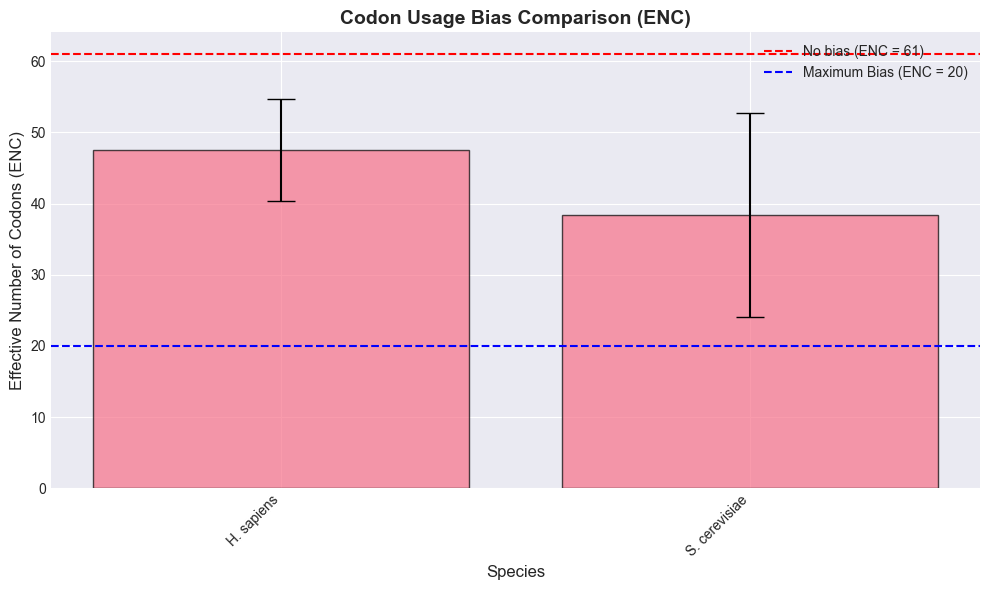

In [62]:
print("\n" + "=" * 70)
print("VISUALIZATION 1: ENC (Effective Number of Codons) Comparison")
print("=" * 70)
print("Interpretation:")
print("  • ENC close to 61 = low bias (uses all codons equally)")
print("  • ENC close to 20 = high bias (strong codon preference)")
print("  • Bacteria typically show lower ENC than eukaryotes")
analyzer.plot_enc_comparison()


VISUALIZATION 2: RSCU Heatmap for Leucine (6-fold degenerate)
Interpretation:
  • RSCU = 1.0 (green) = no bias
  • RSCU > 1.0 (bright green) = codon used more than expected
  • RSCU < 1.0 (yellow/red) = codon used less than expected


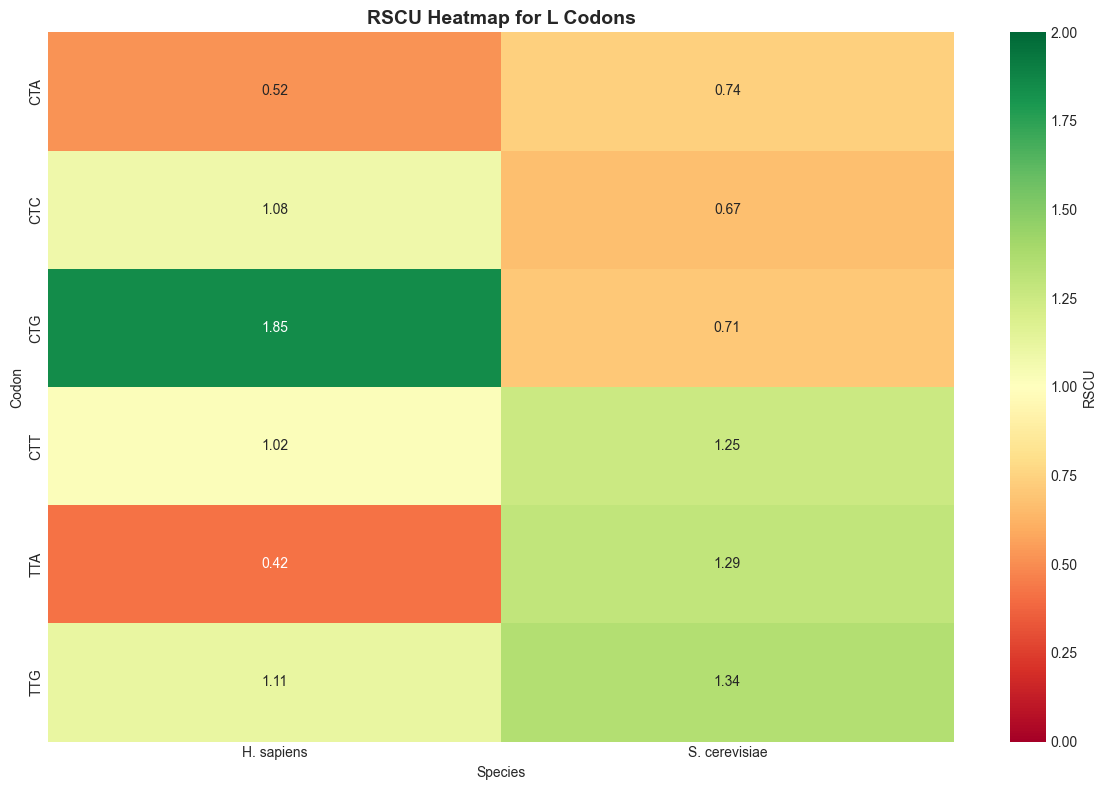

In [63]:
print("\n" + "=" * 70)
print("VISUALIZATION 2: RSCU Heatmap for Leucine (6-fold degenerate)")
print("=" * 70)
print("Interpretation:")
print("  • RSCU = 1.0 (green) = no bias")
print("  • RSCU > 1.0 (bright green) = codon used more than expected")
print("  • RSCU < 1.0 (yellow/red) = codon used less than expected")
analyzer.plot_rscu_heatmap(amino_acid='L')


VISUALIZATION 3: GC Content at Codon Positions
Interpretation:
  • GC3 (3rd position) shows most variation due to wobble pairing
  • High GC3 often correlates with expression level
  • GC1 and GC2 more constrained by amino acid coding


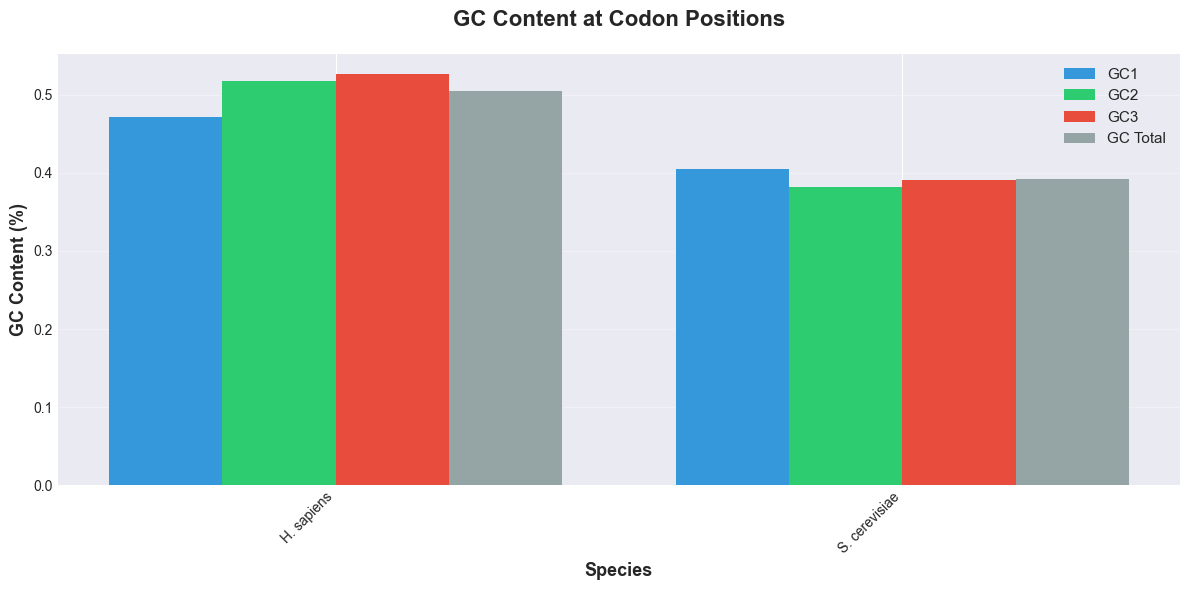

In [65]:
print("\n" + "=" * 70)
print("VISUALIZATION 3: GC Content at Codon Positions")
print("=" * 70)
print("Interpretation:")
print("  • GC3 (3rd position) shows most variation due to wobble pairing")
print("  • High GC3 often correlates with expression level")
print("  • GC1 and GC2 more constrained by amino acid coding")
gc_df = analyzer.plot_gc_content()

## ANOTHER ONE

In [66]:
analyzer = CodonUsageAnalyzer()

In [67]:
def fetch_sequences_from_genome(accession, num_genes=50):
    """
    Fetch CDS sequences directly from a genome accession
    
    Parameters:
    -----------
    accession : str
        Genome accession (e.g., "NC_000913" for E. coli K-12)
    num_genes : int
        Number of genes to extract
    
    Returns:
    --------
    list : List of DNA sequences
    """
    print(f"\n{'='*70}")
    print(f"Fetching CDS from genome: {accession}")
    print(f"{'='*70}\n")
    
    sequences = []
    
    try:
        print("Downloading genome annotation...")
        genome_handle = Entrez.efetch(
            db="nuccore",
            id=accession,
            rettype="gb",
            retmode="text"
        )
        
        genome_record = SeqIO.read(genome_handle, "genbank")
        genome_handle.close()
        
        print(f"✓ Genome loaded: {len(genome_record)} bp, {len(genome_record.features)} features")
        print(f"\nExtracting CDS features...")
        
        cds_count = 0
        for feature in genome_record.features:
            if feature.type == "CDS" and cds_count < num_genes:
                try:
                    cds_seq = str(feature.extract(genome_record.seq))
                    if len(cds_seq) >= 300 and len(cds_seq) % 3 == 0:
                        sequences.append(cds_seq.upper())
                        cds_count += 1
                        
                        if cds_count % 10 == 0:
                            print(f"  Extracted {cds_count} CDS...")
                except:
                    continue
        
        print(f"\n✅ Successfully extracted {len(sequences)} CDS from genome")
        
    except Exception as e:
        print(f"❌ Error fetching genome: {e}")
    
    return sequences

In [68]:
print("\n" + "="*70)
print("DATA SOURCE: NCBI Reference Genomes")
print("="*70)
print("\n💡 Using reference genomes is more reliable than gene-by-gene search")
print("📋 Will try multiple organisms to ensure we get data\n")

# Track which species were successfully added
successful_species = []

# Example 1: Mycoplasma genitalium (smallest bacterial genome - very reliable)
print("\n" + "="*70)
print("Species 1: Mycoplasma genitalium (smallest bacterial genome)")
print("="*70)
myco_seqs = fetch_sequences_from_genome("NC_000908.2", num_genes=50)
if len(myco_seqs) > 0:
    analyzer.add_species("M. genitalium", myco_seqs)
    successful_species.append("M. genitalium")

# Example 2: Bacillus subtilis (Gram-positive bacterium)
print("\n" + "="*70)
print("Species 2: Bacillus subtilis")
print("="*70)
bacillus_seqs = fetch_sequences_from_genome("NC_000964.3", num_genes=50)
if len(bacillus_seqs) > 0:
    analyzer.add_species("B. subtilis", bacillus_seqs)
    successful_species.append("B. subtilis")

# Example 3: Haemophilus influenzae (first bacterial genome sequenced)
print("\n" + "="*70)
print("Species 3: Haemophilus influenzae")
print("="*70)
haemo_seqs = fetch_sequences_from_genome("NC_000907.1", num_genes=50)
if len(haemo_seqs) > 0:
    analyzer.add_species("H. influenzae", haemo_seqs)
    successful_species.append("H. influenzae")

# Example 4: Yeast (Saccharomyces cerevisiae - chromosome I)
print("\n" + "="*70)
print("Species 4: Saccharomyces cerevisiae (Yeast)")
print("="*70)
yeast_seqs = fetch_sequences_from_genome("NC_001133.9", num_genes=50)
if len(yeast_seqs) > 0:
    analyzer.add_species("S. cerevisiae", yeast_seqs)
    successful_species.append("S. cerevisiae")

# Example 5: Try E. coli as backup
print("\n" + "="*70)
print("Species 5: Escherichia coli K-12 (if available)")
print("="*70)
ecoli_seqs = fetch_sequences_from_genome("NC_000913.3", num_genes=50)
if len(ecoli_seqs) > 0:
    analyzer.add_species("E. coli K-12", ecoli_seqs)
    successful_species.append("E. coli K-12")

# Example 6: Human genes (gene-by-gene approach for large genome)
print("\n" + "="*70)
print("Species 6: Homo sapiens (selected genes)")
print("="*70)
human_genes = ['GAPDH', 'ACTB', 'ALB']
human_seqs, human_meta = fetch_coding_sequences_from_ncbi(
    organism="Homo sapiens",
    gene_list=human_genes,
    max_sequences=3
)
if len(human_seqs) > 0:
    analyzer.add_species("H. sapiens", human_seqs)
    successful_species.append("H. sapiens")

# Example 7: Drosophila melanogaster (fruit fly)
print("\n" + "="*70)
print("Species 7: Drosophila melanogaster (Fruit fly - chromosome 4)")
print("="*70)
droso_seqs = fetch_sequences_from_genome("NC_004353.4", num_genes=30)
if len(droso_seqs) > 0:
    analyzer.add_species("D. melanogaster", droso_seqs)
    successful_species.append("D. melanogaster")

# Example 8: Arabidopsis thaliana (model plant - chloroplast)
print("\n" + "="*70)
print("Species 8: Arabidopsis thaliana (Plant - chloroplast genome)")
print("="*70)
arab_seqs = fetch_sequences_from_genome("NC_000932.1", num_genes=40)
if len(arab_seqs) > 0:
    analyzer.add_species("A. thaliana (chloroplast)", arab_seqs)
    successful_species.append("A. thaliana")

# Summary of loaded species
print("\n" + "="*70)
print("SPECIES LOADING SUMMARY")
print("="*70)
if successful_species:
    print(f"✅ Successfully loaded {len(successful_species)} species:")
    for sp in successful_species:
        print(f"   • {sp}")
else:
    print("❌ No species data loaded!")
    print("\n💡 TROUBLESHOOTING:")
    print("   1. Check internet connection")
    print("   2. Verify Entrez.email is set")
    print("   3. NCBI may be experiencing issues - try again later")
    print("   4. Consider downloading FASTA files manually from:")
    print("      https://www.ncbi.nlm.nih.gov/genome/")
print("="*70)


DATA SOURCE: NCBI Reference Genomes

💡 Using reference genomes is more reliable than gene-by-gene search
📋 Will try multiple organisms to ensure we get data


Species 1: Mycoplasma genitalium (smallest bacterial genome)

Fetching CDS from genome: NC_000908.2

✓ Genome loaded: 580076 bp, 1133 features

Extracting CDS features...

✅ Successfully extracted 0 CDS from genome

Species 2: Bacillus subtilis

Fetching CDS from genome: NC_000964.3

✓ Genome loaded: 4215606 bp, 1 features

Extracting CDS features...

✅ Successfully extracted 0 CDS from genome

Species 3: Haemophilus influenzae

Fetching CDS from genome: NC_000907.1

✓ Genome loaded: 1830138 bp, 1 features

Extracting CDS features...

✅ Successfully extracted 0 CDS from genome

Species 4: Saccharomyces cerevisiae (Yeast)

Fetching CDS from genome: NC_001133.9

✓ Genome loaded: 230218 bp, 325 features

Extracting CDS features...

✅ Successfully extracted 0 CDS from genome

Species 5: Escherichia coli K-12 (if available)

Fetching


GENERATING VISUALIZATIONS AND STATISTICS

CODON USAGE ANALYSIS SUMMARY

H. sapiens:
  Sequences analyzed: 3
  Total codons counted: 5961
  ENC: 47.55 ± 7.19
  GC Content: 50.5% (GC3: 52.6%)
  Most biased codon: AGA (R) - RSCU: 2.59

A. thaliana (chloroplast):
  Sequences analyzed: 40
  Total codons counted: 13392
  ENC: 41.13 ± 3.85
  GC Content: 38.8% (GC3: 28.1%)
  Most biased codon: TTA (L) - RSCU: 2.30

CREATING COMPARISON DATAFRAME

First 10 rows of comparison data:
      Species Codon Amino_Acid      RSCU  Count
0  H. sapiens   TTT          F  1.285141    160
1  H. sapiens   TTC          F  0.714859     89
2  H. sapiens   TTA          L  0.421725     44
3  H. sapiens   TTG          L  1.111821    116
4  H. sapiens   CTT          L  1.015974    106
5  H. sapiens   CTC          L  1.083067    113
6  H. sapiens   CTA          L  0.517572     54
7  H. sapiens   CTG          L  1.849840    193
8  H. sapiens   TCT          S  1.039451    101
9  H. sapiens   TCC          S  0.936535   

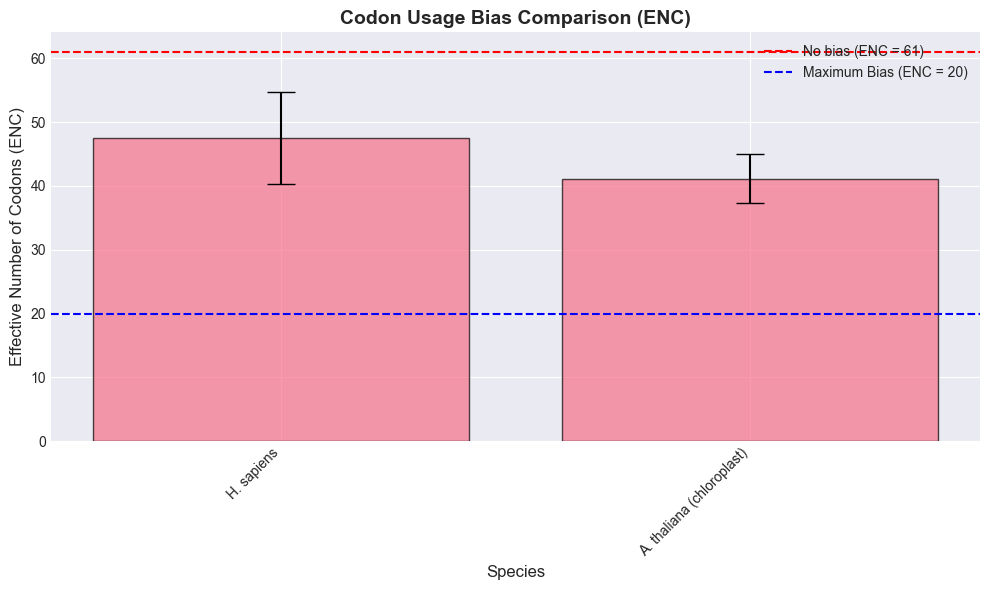


VISUALIZATION 2: RSCU Heatmap for Leucine (6-fold degenerate)
Interpretation:
  • RSCU = 1.0 (green) = no bias
  • RSCU > 1.0 (bright green) = codon used more than expected
  • RSCU < 1.0 (yellow/red) = codon used less than expected


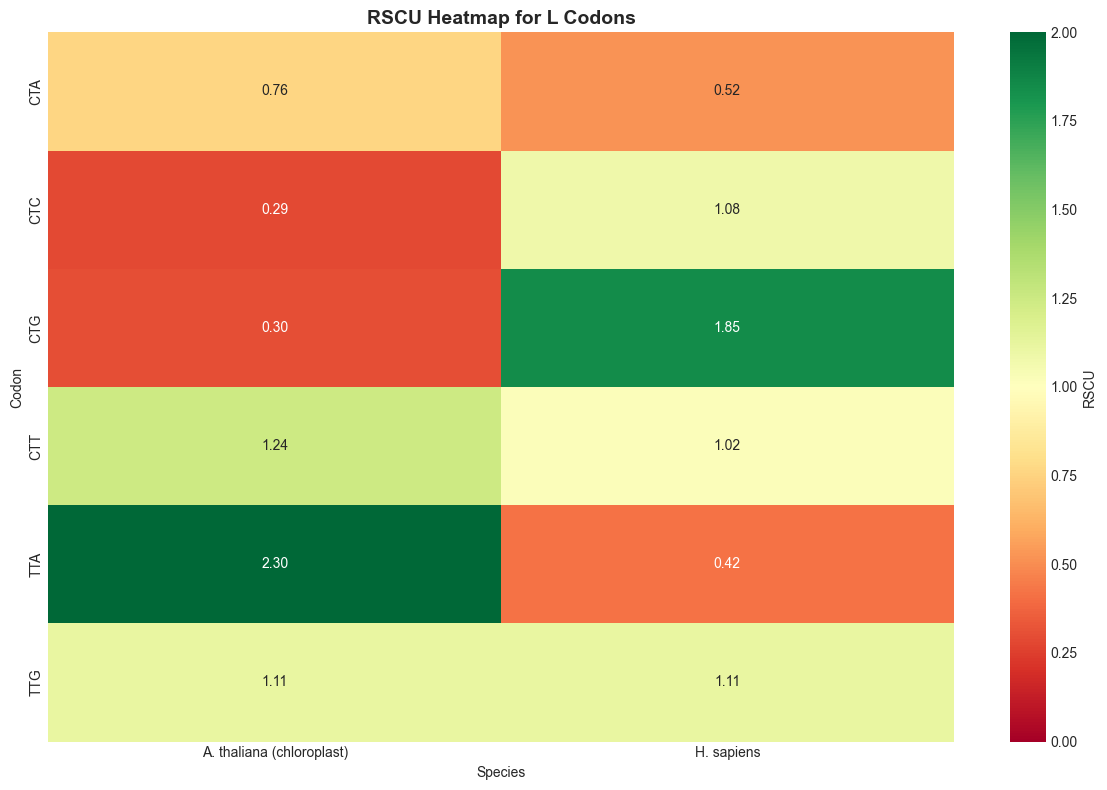


VISUALIZATION 3: GC Content at Codon Positions
Interpretation:
  • GC3 (3rd position) shows most variation due to wobble pairing
  • High GC3 often correlates with expression level
  • GC1 and GC2 more constrained by amino acid coding


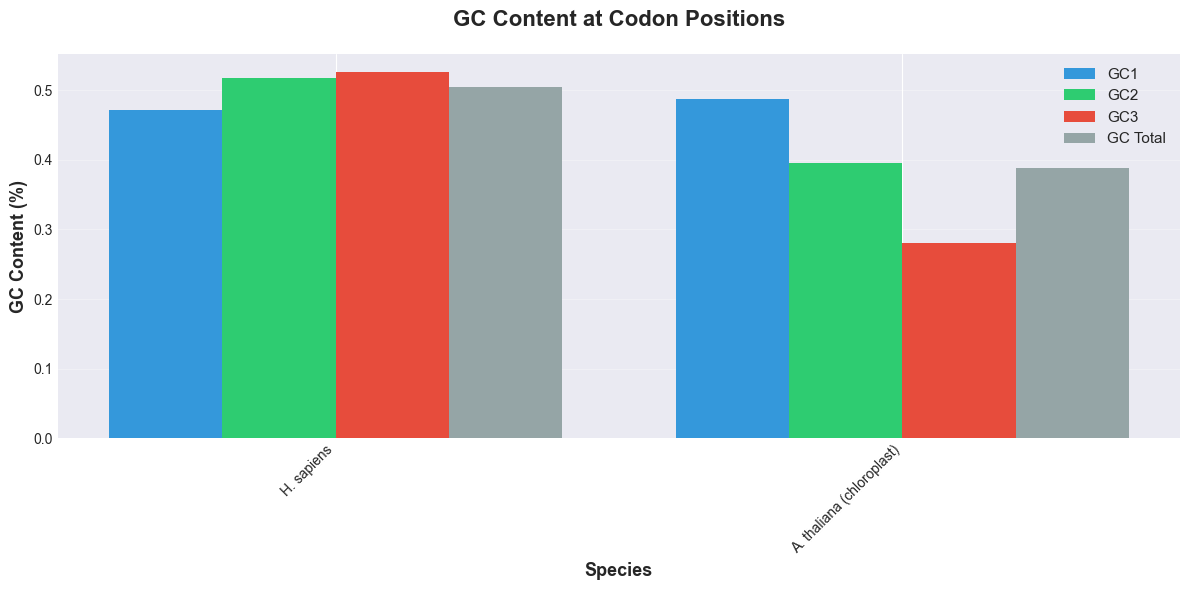

In [70]:
# =============================================================================
# PERFORM COMPREHENSIVE ANALYSIS
# =============================================================================

print("\n" + "=" * 70)
print("GENERATING VISUALIZATIONS AND STATISTICS")
print("=" * 70)

# Check if we have any species data
if not analyzer.species_data:
    print("\n" + "!" * 70)
    print("ERROR: No species data was successfully loaded!")
    print("!" * 70)
    print("\n📝 Troubleshooting tips:")
    print("1. Check your internet connection")
    print("2. Verify Entrez.email is set to a valid email")
    print("3. Try using local FASTA files instead (see OPTION 2 below)")
    print("4. Some genes may have different nomenclature - check NCBI Gene database")
    print("\n💡 Alternative: Download CDS FASTA files from:")
    print("   - E. coli: https://www.ncbi.nlm.nih.gov/nuccore/NC_000913")
    print("   - Human: https://www.ncbi.nlm.nih.gov/gene")
    print("   - Yeast: https://www.yeastgenome.org/")
    print("\n" + "=" * 70)
    
else:
    # Print summary statistics
    analyzer.print_summary()

    # Generate comparison dataframe
    print("\n" + "=" * 70)
    print("CREATING COMPARISON DATAFRAME")
    print("=" * 70)
    comparison_df = analyzer.compare_species()
    print("\nFirst 10 rows of comparison data:")
    print(comparison_df.head(10))

    # Save to CSV
    comparison_df.to_csv("codon_usage_comparison.csv", index=False)
    print("\n✓ Full comparison data saved to 'codon_usage_comparison.csv'")

    # =============================================================================
    # VISUALIZATION 1: ENC Comparison
    # =============================================================================

    print("\n" + "=" * 70)
    print("VISUALIZATION 1: ENC (Effective Number of Codons) Comparison")
    print("=" * 70)
    print("Interpretation:")
    print("  • ENC close to 61 = low bias (uses all codons equally)")
    print("  • ENC close to 20 = high bias (strong codon preference)")
    print("  • Bacteria typically show lower ENC than eukaryotes")
    analyzer.plot_enc_comparison()

    # =============================================================================
    # VISUALIZATION 2: RSCU Heatmap for Leucine
    # =============================================================================

    print("\n" + "=" * 70)
    print("VISUALIZATION 2: RSCU Heatmap for Leucine (6-fold degenerate)")
    print("=" * 70)
    print("Interpretation:")
    print("  • RSCU = 1.0 (green) = no bias")
    print("  • RSCU > 1.0 (bright green) = codon used more than expected")
    print("  • RSCU < 1.0 (yellow/red) = codon used less than expected")
    analyzer.plot_rscu_heatmap(amino_acid='L')

    # =============================================================================
    # VISUALIZATION 3: GC Content Analysis
    # =============================================================================

    print("\n" + "=" * 70)
    print("VISUALIZATION 3: GC Content at Codon Positions")
    print("=" * 70)
    print("Interpretation:")
    print("  • GC3 (3rd position) shows most variation due to wobble pairing")
    print("  • High GC3 often correlates with expression level")
    print("  • GC1 and GC2 more constrained by amino acid coding")

    gc_df = analyzer.plot_gc_content()